# Algebra Lineal Computacional
# **Trabajo Práctico N°1**

---

### **Alumno:** Jack

---


## Descomposición LU

Se importan las bibliotecas que serán usadas en toda la notebook e inicializa la semilla de números aleatorios de numpy.

In [1]:
import numpy as np
from tqdm import tqdm
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt

In [2]:
seed = 42
np.random.seed(seed)

### Ejercicio 1

Partiendo de la descomposición dada y los despejes, se puede comenzar por pensar el caso base del algoritmo como el de una matriz de 1x1.

Teniendo el caso base definido, el siguiente paso es seguir con una matriz de 2x2, para lo cual usamos el mismo algoritmo enunciado en el TP.

Se decidió definir una función `computarLU` como lo pide el ejercicio, pero además una función `computarLUconError` que verifica que en la primera posición de la primera fila de la matriz nunca haya un cero, y de haberlo, devuelva una booleano que indique del error, para que `computarLU` se encargue de mostrar el mensaje de error correspondiente.

De esta manera se evita tener que comparar matrices entre recursiones para diferenciar si lo que se devolvió es una descomposición LU o si es la identidad con la matriz original porque no se pudo descomponer esa matriz particular.

In [3]:
def rearmarMatriz(u11, U12, L21, L22, U22):
    """
    Función auxiliar que construye la descomposición LU de una matriz a partir de sus componentes.

    Args:
        u11: Primer elemento diagonal.
        U12: Elementos superiores de la primera fila.
        L21: Elementos inferiores de la primera columna.
        L22: Matriz triangular inferior.
        U22: Matriz triangular superior.

    Returns:
        numpy.ndarray: La descomposición LU de la matriz correspondiente.
    """
    n = L22.shape[0] + 1
    L = np.eye(n)
    U = np.zeros((n, n))

    L[1:n, 0:1] = L21
    L[1:n, 1:n] = L22

    U[0, 0] = u11
    U[0:1, 1:n] = U12
    U[1:n, 1:n] = U22
    return L, U

def computarLUconError(A, verbose=True):
    """
    Realiza la factorización LU de una matriz a partir de su descomposición en 4 bloques.

    Args:
        A (numpy.ndarray): La matriz de entrada.
        verbose (bool): Controla si se imprimen mensajes de error. (predeterminado es True)

    Returns:
        Tuple: Una tupla con las matrices L y U de la factorización LU.
    """
    n = A.shape[0]

    err = False
    if A[0, 0] == 0:
        # No se puede realizar la factorización LU (sin pivoteo)
        err = True
        return np.eye(n), A, err
    
    if n == 1:
        # Caso base: Matriz 1x1
        return np.eye(1), A, err

    # Separo matriz en bloques
    u11 = A[0, 0]
    U12 = A[0:1, 1:n]        # Se escribe el primer elemento de la primera/segunda
    L21 = A[1:n, 0:1] / u11  # dimensión como rango para no perder la dimensionalidad
    A22 = A[1:n, 1:n]
    
    L22U22 = A22 - (L21 @ U12)

    L22, U22, err = computarLUconError(L22U22, verbose)

    # Si hubo un error al calcular la factorización LU de L22U22
    if err:
        return np.eye(n), A, err

    L, U = rearmarMatriz(u11, U12, L21, L22, U22)

    return L, U, err

def computarLU(A, verbose=True):
    """
    Llama a computarLUconError y devuelve las matrices L y U.
    En caso de error, devuelve las matrices Identidad y A.
    
    Args:
        A (numpy.ndarray): La matriz de entrada.
        verbose (bool): Controla si se imprimen mensajes de error. (predeterminado es True)

    Returns:
        Tuple: Una tupla con las matrices L y U de la factorización LU.
    """
    L, U, err = computarLUconError(A, verbose)

    if err and verbose:
        print("Error! No se puede computar la factorización LU!")
    
    return L, U

#### Verificación y Test

A continuación se definen dos funciones que verifican un caso particular con un cero en la diagonal en un 2do paso de la descomposición LU y el testeo de la función `computarLU` sobre una gran cantidad de matrices aleatorias de distintas dimensiones.

In [4]:
def testLUNoValida():
    """
    Realiza una prueba de la función computarLU con una matriz A que puede ser descompuesta en matrices LU (sin pivoteo).
    Imprime los valores devueltos por la función, incluyendo las matrices L y U.

    Args:
        None
    
    Returns:
        None
    """
    A = np.asarray([[1., 2., 3., 4.],
                    [2.,6.,10.,6.],
                    [0.,2.,4.,7.],
                    [0.,0.,11.,3.]])
    
    L, U = computarLU(A, verbose=True)
    print("Valores devueltos:")
    print("L:\n", L)
    print("U:\n", U)

testLUNoValida()

Error! No se puede computar la factorización LU!
Valores devueltos:
L:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
U:
 [[ 1.  2.  3.  4.]
 [ 2.  6. 10.  6.]
 [ 0.  2.  4.  7.]
 [ 0.  0. 11.  3.]]


In [5]:
def esTriangSup(A):
    """
    Comprueba si una matriz es triangular superior.

    Args:
        A (numpy.ndarray): La matriz a ser comprobada.

    Returns:
        bool: True si la matriz es triangular superior, False en caso contrario.
    """
    return np.array_equal(A, np.triu(A))

def esTriangInf(A):
    """
    Comprueba si una matriz es triangular inferior.

    Args:
        A (numpy.ndarray): La matriz a ser comprobada.

    Returns:
        bool: True si la matriz es triangular inferior, False en caso contrario.
    """
    return np.array_equal(A, np.tril(A))

def testLUFlotantes(dimensiones=[2,3,4,5,10], cantidad=10_000):
    """
    Prueba la función computarLUconError utilizando matrices aleatorias de punto flotante.

    Args:
        dimensiones (list): Lista de dimensiones de matrices a probar (predeterminado es [2, 3, 4, 5, 10]).
        cantidad (int): Cantidad de matrices aleatorias a generar y probar para cada dimensión (predeterminado es 10_000).

    Returns:
        None
    """
    tolerancia = 0.01
    no_validas = []
    for n in tqdm(dimensiones):
        count_valid = 0
        matrices_aleatorias = [np.random.uniform(low=-1, high=1, size=(n, n)).astype(np.float32) for i in range(cantidad)]
        for A in matrices_aleatorias:
            L, U, err = computarLUconError(A, verbose=True)

            # La descomposición LU será válida si L es triangular inferior, U es triangular superior,
            # y el producto L @ U es igual a la matriz original A
            if not err and not esTriangInf(L) or not esTriangSup(U) or not np.allclose(A, L @ U, atol=tolerancia):
                no_validas.append((A, L, U))
                continue
            else:
                count_valid += 1
        print(f"{count_valid}/{cantidad} matrices de {n}x{n} correctamente calculadas")
        if len(no_validas) > 0:
            print(f"{len(no_validas)}/{cantidad} matrices de {n}x{n} no se pudieron calcular:")
            for Aerr, Lerr, Uerr in no_validas:
                print("A:\n",Aerr)
                print("L:\n", Lerr)
                print("U:\n", Uerr)
                print("L @ U:\n", Lerr @ Uerr)
                print("A - (L @ U):\n", Aerr - (Lerr @ Uerr))
                print("-"*50)



testLUFlotantes()

 20%|██        | 1/5 [00:01<00:07,  1.79s/it]

10000/10000 matrices de 2x2 correctamente calculadas


 40%|████      | 2/5 [00:03<00:05,  1.82s/it]

10000/10000 matrices de 3x3 correctamente calculadas


 60%|██████    | 3/5 [00:05<00:03,  1.84s/it]

10000/10000 matrices de 4x4 correctamente calculadas


 80%|████████  | 4/5 [00:07<00:01,  1.96s/it]

10000/10000 matrices de 5x5 correctamente calculadas


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]

10000/10000 matrices de 10x10 correctamente calculadas


> Dados los resultados obtenidos de las funciones de test, se concluye que la función `computarLU` calcula correctamente la descomposición LU de matrices de distintas dimensiones.

**Observaciones:**

> Comparar matrices de punto flotante requiere que se tome en cuenta cierta tolerancia, ya que es muy común que luego de algunas operaciones se arrastre algún tipo de error de redondeo. Para eso utilizamos la función `np.allclose` que compara dos matrices posición a posición, y devuelve `true` si todas las comparaciones están dentro de una tolerancia establecida.
> 
> Para evitar que se muestren errores por redondeo al comparar la matriz original `A` con la reconstrucción `L @ U` usamos una tolerancia que podría considerarse alta pero que cumple su objetivo. En caso de querer verificar con más detalle si la descomposición es correcta, podría usarse una tolerancia menor y analizar las diferencias con más detalle.
> 
> No usamos la descomposición LU de bibliotecas de python para comparar si el resultado era correcto ya que no suele implementarse la descomposición LU ***sin pivoteo***.

### Ejercicio 3

In [6]:
def resolverTriangulares(L, U, b, sonTriang=True):
    """
    Resuelve sistemas de ecuaciones lineales utilizando matrices triangulares L y U.

    Args:
        L (numpy.ndarray): Matriz triangular inferior.
        U (numpy.ndarray): Matriz triangular superior.
        b (numpy.ndarray): Vector de términos independientes.

    Returns:
        numpy.ndarray: La solución x del sistema de ecuaciones lineales Ax = b.
    """
    try:
        if sonTriang:
            y = solve_triangular(L, b, lower=True)
            x = solve_triangular(U, y)
        else:
            # L y U no son matrices triangulares. No pudo descomponerse la matriz A.
            # Se resuelve el sistema de ecuaciones lineales utilizando la función solve de numpy
            y = np.linalg.solve(L, b)
            x = np.linalg.solve(U, y)
    except Exception as e:
        print("Error al resolver sistema de ecuaciones lineales! Matriz no inversible.")
        print(e)
        return None
    return x

In [7]:
def resolverLU(A, b):
    """
    Resuelve un sistema de ecuaciones lineales Ax = b utilizando la descomposición LU.

    Args:
        A (numpy.ndarray): La matriz cuadrada de coeficientes del sistema.
        b (numpy.ndarray): El vector de términos independientes.

    Returns:
        numpy.ndarray: El vector solución x (en caso que pueda descomponerse la matriz A)
    """
    L, U, err = computarLUconError(A)

    # En caso que se devuelva error de descomposición, asumimos que las matrices no son triangulares    
    sonTriang = not err

    x = resolverTriangulares(L, U, b, sonTriang)
    
    return x

**Observación:**

> `solve_triangular` asume que las matrices de entradas `L` y `U` son triangulares. En caso de que no lo sean, producirá resultados incorrectos sin mostrar ningún tipo de error. Ésto es importante a tener en cuenta en caso de usar esta función en conjunto con la función `computarLU` de este TP, que puede devolver matrices identidad y la matriz original como resultado en caso de que no pueda computarse la descomposición LU.
>
> Es por eso que agregamos en `resolverTriangulares` el caso donde la descomposición LU no pudo ser computada, resolviendo el sistema utilizando la función `linalg.solve` de numpy. 

### Ejercicio 4

Usaremos la función `np.random.uniform` de numpy, que permite generar números aleatorios generados bajo una distribución uniforme, con la cual podemos elegir convenientemente valores mínimos y máximos necesarios para este ejercicio.

En primer lugar definimos valores aleatorios a usar, resolvemos el sistema usando la función `resolverLU` del ejercicio 3, y definimos las funciones de error requeridas en un formato que puedan ser usadas en ejercicios posteriores.

In [8]:
n = 10 # Dimensionalidad
A = np.random.uniform(low=-1., high=1., size=(n, n))
b = np.random.uniform(low=-1., high=1., size=(n, 1))
x = resolverLU(A, b)

In [9]:
def errorRelativo(xi, x):
    """
    Calcula el error relativo en norma-2 entre dos vectores.

    Args:
        xi (numpy.ndarray): El vector aproximado.
        x (numpy.ndarray): El vector original.

    Returns:
        float: El error relativo en norma-2.
    """
    e = np.linalg.norm(xi - x) / np.linalg.norm(x)
    return e

In [10]:
def calcularError(A, b, x):
    """
    Calcula el error relativo en norma-2 de un sistema de ecuaciones lineales.

    Args:
        A (numpy.ndarray): La matriz de coeficientes del sistema.
        b (numpy.ndarray): El vector de términos independientes.
        x (numpy.ndarray): El vector de solución calculado.

    Returns:
        float: El error relativo en norma-2.
    """
    e = errorRelativo(A @ x, b)
    return e

Error resultante para una matriz aleatoria `A` de 10 x 10:

In [11]:
err = calcularError(A, b, x)
print("Error relativo:", err)

Error relativo: 4.905757329624772e-14


## Cálculo de la inversa

### Ejercicio 5

In [12]:
def inversa(A):
    """
    Calcula la matriz inversa de una matriz cuadrada A utilizando la descomposición LU.

    Args:
        A (numpy.ndarray): La matriz cuadrada inversible de tamaño n x n.

    Returns:
        numpy.ndarray: La matriz inversa de A.
    """
    n = A.shape[0]
    I = np.eye(n)
    A_inv = np.zeros((n, n))

    L, U = computarLU(A)
    for i in range(n):
        A_inv[:, i] = resolverTriangulares(L, U, I[:, i])
    return A_inv

**Observaciones:**

> Para este ejercicio decidimos computar la descomposición LU antes de resolver cada uno de los sistemas de matrices triangulares, de forma que no tengamos que calcular la misma descomposición LU más de una vez. Para matrices grandes la diferencia de tiempo de ejecución es sustancial (crece linealmente n) y para los ejercicios 7 y 8 con centenares de experimentos se pasa de un tiempo de ~1.5 minutos a ~60.0 minutos de tiempo de ejecución.
>
> Otra forma más eficiente de implementar la inversa podría haber sido calcular todos los sistemas con los vectores $e_i$ pasando como parámetro la totalidad de la matriz identidad `I`, eliminando el for loop. Decidimos no hacerlo ya que la función `resolverTriangulares` fue definida para un vector `b` de términos independientes, y no una matriz. Sabemos que la función de scipy funcionaría de la misma manera, pero preferimos que quede escrito de manera explicita en nuestra función para evitar cualquier tipo de confusión.

### Ejercicio 6

In [13]:
def errorFrobenius(A, A_inv):
    """
    Calcula el error en norma Frobenius entre A * A^-1 y la matriz identidad.

    Args:
        A (numpy.ndarray): La matriz original de tamaño n x n.
        A_inv (numpy.ndarray): La matriz inversa de A.

    Returns:
        float: El error en norma Frobenius.
    """
    I = np.eye(A.shape[0])
    e = np.linalg.norm(A @ A_inv - I, ord='fro')
    return e

In [14]:
n = 10 # Dimensionalidad
A = np.random.uniform(low=-1., high=1., size=(n, n))
b = np.random.uniform(low=-1., high=1., size=(n, 1))

In [15]:
A_inv = inversa(A)
e = errorFrobenius(A, A_inv)
print("Error en norma Frobenius:", e)

Error en norma Frobenius: 2.4278466981779598e-14


## Experimentos

### Ejercicio 7 y 8

Juntamos los ejercicios 7 y 8 en una misma función ya que comparten gran parte del código. El ejercicio 9 también es muy similar, pero como devuelve 4 parámetros en vez de 2, elegimos hacer una función por separado para no complicar demasiado la función por querer incluir todos los experimentos en la misma pieza de código.

In [16]:
def errores_ej7(A, x):
    """
    Calcula el error relativo entre Ax y b en escala logarítmica para una matriz A y un vector x dados.

    Args:
        A (numpy.ndarray): La matriz A.
        x (numpy.ndarray): El vector x.

    Returns:
        Tuple: Una tupla que contiene dos errores calculados como logaritmo natural:
            - e1: Error al resolver el sistema Ax = b utilizando la función resolverLU.
            - e2: Error al resolver el sistema Ax = b utilizando la función inversa.
    """
    b = A @ x
    x1 = resolverLU(A, b)
    e1 = calcularError(A, b, x1)
    e1 = np.log(e1)

    x2 = inversa(A) @ b
    e2 = calcularError(A, b, x2)
    e2 = np.log(e2)

    return e1, e2

In [17]:
def errores_ej8(A, x):
    """
    Calcula el error relativo entre xi y x en escala logarítmica para una matriz A y un vector x dados.

    Args:
        A (numpy.ndarray): La matriz A.
        x (numpy.ndarray): El vector x.

    Returns:
        Tuple: Una tupla que contiene dos errores relativos calculados en escala logarítmica:
            - e1: Error relativo al resolver el sistema Ax = b utilizando la función resolverLU.
            - e2: Error relativo al resolver el sistema Ax = b utilizando la función inversa.
    """
    b = A @ x
    x1 = resolverLU(A, b)
    e1 = errorRelativo(x1, x)
    e1 = np.log(e1)

    x2 = inversa(A) @ b
    e2 = errorRelativo(x2, x)
    e2 = np.log(e2)

    return e1, e2

In [18]:
def experimento(ejercicio, min_dim=10, max_dim=200, iteraciones=10, step=1):
    """
    Realiza un experimento con matrices aleatorias de diversas dimensiones y calcula errores relativos.

    Args:
        ejercicio (int): El número de ejercicio a realizar (7 o 8).
        min_dim (int): Dimensión mínima de las matrices.
        max_dim (int): Dimensión máxima de las matrices.
        iteraciones (int): Número de iteraciones por cada dimensión.
        step (int): Paso entre dimensiones.

    Returns:
        Tuple: Una tupla con los siguientes elementos en orden:
            - v1 (list): Errores cometidos por el método con LU.
            - v2 (list): Errores cometidos por el método con inversa.
    """
    assert ejercicio in [7, 8], "Ejercicio no valido. Debe ser 7 u 8"

    dimensiones = np.arange(min_dim, max_dim, step)

    # Las primeras min_dim posiciones se llenan con ceros para respetar que el indice
    # del vector se corresponda con la dimension de las matrices del experimento
    v1, v2 = [0]*min_dim, [0]*min_dim

    for n in tqdm(dimensiones):
        sum_e1 = 0
        sum_e2 = 0

        for i in range(iteraciones):
            A = np.random.uniform(low=-1., high=1., size=(n, n))
            x = np.random.uniform(low=-1., high=1., size=(n, 1))
            
            if ejercicio == 7:
                e1, e2 = errores_ej7(A, x)
            else: 
                #ejercicio == 8
                e1, e2 = errores_ej8(A, x)

            sum_e1 += e1
            sum_e2 += e2

        v1.append(sum_e1)
        v2.append(sum_e2)
        
    return v1, v2

In [19]:
min_dim = 10
max_dim = 200
iteraciones=10
step = 1

v1, v2 = experimento(ejercicio=7, min_dim=min_dim, max_dim=max_dim, iteraciones=iteraciones, step=step)

100%|██████████| 190/190 [01:02<00:00,  3.04it/s]


In [20]:
# Tamaño de las figuras de matplotlib
plt.rcParams['figure.figsize'] = [10, 5]

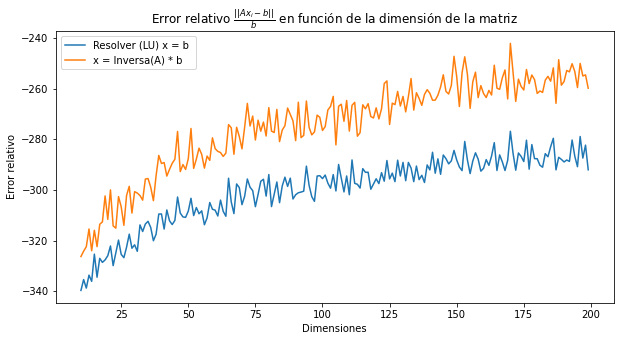

In [21]:
plt.plot(np.arange(min_dim, max_dim, step), v1[min_dim:], label="Resolver (LU) x = b ")
plt.plot(np.arange(min_dim, max_dim, step), v2[min_dim:], label="x = Inversa(A) * b")
plt.title("Error relativo " r"$\frac{||Ax_i - b||}{b}$" + " en función de la dimensión de la matriz")
plt.xlabel("Dimensiones")
plt.ylabel("Error relativo")
plt.legend()
plt.show()

> **¿Qué conclusión pueden obtener del gráfico?**
>
>Se observa que ambas curvas tienen pendiente positiva y se mantienen separadas a una distancia que crece lentamente a medida que crecen las dimensiones.
>
>Teniendo en cuenta que se grafica el **logaritmo** de los errores, podemos decir que a medida que la dimensión crece, el error crece de manera exponencial en ambos casos, y también la distancia del error entre los distintos métodos crece de manera exponencial 

In [22]:
min_dim = 10
max_dim = 200
iteraciones=10
step = 1

v1, v2 = experimento(ejercicio=8, min_dim=min_dim, max_dim=max_dim, iteraciones=iteraciones, step=step)

100%|██████████| 190/190 [01:01<00:00,  3.08it/s]


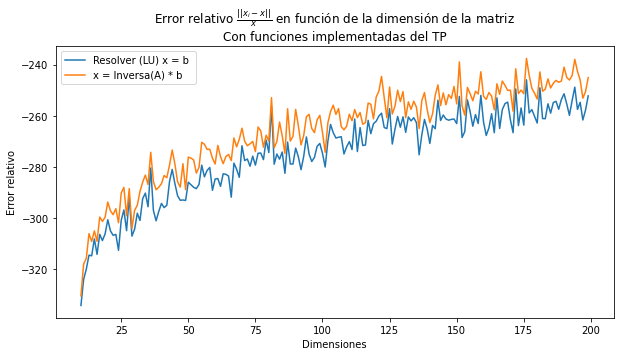

In [23]:
plt.plot(np.arange(min_dim, max_dim, step), v1[min_dim:], label="Resolver (LU) x = b ")
plt.plot(np.arange(min_dim, max_dim, step), v2[min_dim:], label="x = Inversa(A) * b")
plt.title("Error relativo " r"$\frac{||x_i - x||}{x}$" + " en función de la dimensión de la matriz\nCon funciones implementadas del TP")
plt.xlabel("Dimensiones")
plt.ylabel("Error relativo")
plt.legend()
plt.show()

> **¿Observan el mismo comportamiento?**
>
> No, no se observa el mismo comportamiento en cuanto a la diferencia de los distintos métodos. En el experimento anterior los errores se encontraban más separados para todas las dimensiones, mientras que en este caso los errores son muy parecidos sin importar la dimensión.
>
> Lo que sí se observa como un mismo tipo de comportamiento es que el error relativo aumente de manera proporcional a la dimensión de la matriz.

### Ejercicio 9

In [24]:
def errores_ej9(A, x):
    """
    Calcula varios errores relativos en escala logarítmica para una matriz A y un vector x dados.

    Args:
        A (numpy.ndarray): La matriz A.
        x (numpy.ndarray): El vector x.

    Returns:
        Tuple: Una tupla que contiene cuatro errores relativos calculados en escala logarítmica:
            - e7_1: Error relativo al resolver el sistema Ax = b utilizando np.linalg.solve.
            - e7_2: Error relativo al resolver el sistema Ax = b utilizando np.linalg.inv.
            - e8_1: Error relativo en la solución x1 obtenida al resolver Ax = b utilizando np.linalg.solve.
            - e8_2: Error relativo en la solución x2 obtenida al resolver Ax = b utilizando np.linalg.inv.
    """
    b = A @ x

    x1 = np.linalg.solve(A, b)
    e7_1 = calcularError(A, b, x1)
    e7_1 = np.log(e7_1)
    e8_1 = errorRelativo(x1, x)
    e8_1 = np.log(e8_1)

    x2 = np.linalg.inv(A) @ b
    e7_2 = calcularError(A, b, x2)
    e7_2 = np.log(e7_2)
    e8_2 = errorRelativo(x2, x)
    e8_2 = np.log(e8_2)

    return e7_1, e7_2, e8_1, e8_2

In [25]:
def experimento_ej9(min_dim=10, max_dim=200, iteraciones=10, step=1):
    """
    Realiza un experimento con matrices aleatorias de diversas dimensiones y calcula errores relativos utilizando np.linalg.solve y np.linalg.inv.

    Args:
        min_dim (int): Dimensión mínima de las matrices.
        max_dim (int): Dimensión máxima de las matrices.
        iteraciones (int): Número de iteraciones por cada dimensión.
        step (int): Paso entre dimensiones.

    Returns:
        dict: Un diccionario con los siguientes elementos:
            - 'e7_1' (list): Errores relativos en escala logarítmica al resolver el sistema Ax = b utilizando np.linalg.solve.
            - 'e7_2' (list): Errores relativos en escala logarítmica al resolver el sistema Ax = b utilizando np.linalg.inv.
            - 'e8_1' (list): Errores relativos en escala logarítmica en la solución x1 obtenida al resolver Ax = b utilizando np.linalg.solve.
            - 'e8_2' (list): Errores relativos en escala logarítmica en la solución x2 obtenida al resolver Ax = b utilizando np.linalg.inv.
    """
    dimensiones = np.arange(min_dim, max_dim, step)

    resultados = {}
    # Las primeras min_dim posiciones se llenan con ceros para respetar que el indice
    # del vector se corresponda con la dimension de las matrices del experimento
    resultados["e7_1"] = [0]*min_dim
    resultados["e7_2"] = [0]*min_dim
    resultados["e8_1"] = [0]*min_dim
    resultados["e8_2"] = [0]*min_dim

    for n in tqdm(dimensiones):
        sum_e7_1 = 0
        sum_e7_2 = 0
        sum_e8_1 = 0
        sum_e8_2 = 0
        for i in range(iteraciones):
            A = np.random.uniform(low=-1., high=1., size=(n, n))
            x = np.random.uniform(low=-1., high=1., size=(n, 1))
            
            e7_1, e7_2, e8_1, e8_2 = errores_ej9(A, x)
            sum_e7_1 += e7_1
            sum_e7_2 += e7_2
            sum_e8_1 += e8_1
            sum_e8_2 += e8_2

        resultados["e7_1"].append(sum_e7_1)
        resultados["e7_2"].append(sum_e7_2)
        resultados["e8_1"].append(sum_e8_1)
        resultados["e8_2"].append(sum_e8_2)
    
    return resultados

In [26]:
min_dim = 10
max_dim = 200
iteraciones=10
step = 1

resultados = experimento_ej9(min_dim=min_dim, max_dim=max_dim, iteraciones=iteraciones, step=step)

100%|██████████| 190/190 [00:02<00:00, 78.93it/s] 


In [27]:
v1, v2 = resultados["e7_1"], resultados["e7_2"]

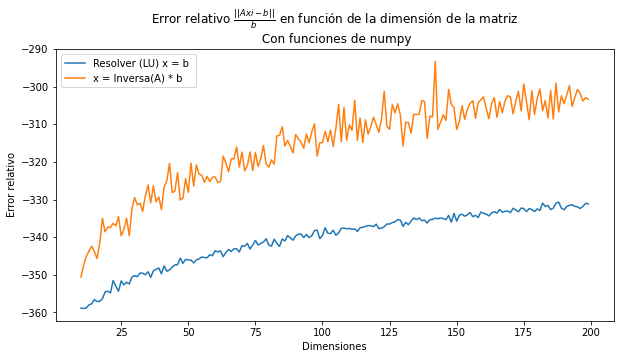

In [28]:
plt.plot(np.arange(min_dim, max_dim, step), v1[min_dim:], label="Resolver (LU) x = b ")
plt.plot(np.arange(min_dim, max_dim, step), v2[min_dim:], label="x = Inversa(A) * b")
plt.title("Error relativo " r"$\frac{||Axi - b||}{b}$" + " en función de la dimensión de la matriz\n Con funciones de numpy")
plt.xlabel("Dimensiones")
plt.ylabel("Error relativo")
plt.legend()
plt.show()

> **¿Observan el mismo comportamiento?**
>
> No. En este caso vemos varias diferencias.
>
> En primer lugar, el método de `Resolver (LU) x = b` tiene mucha menos varianza que todos los resultados anteriores, aun manteniendo todos los parámetros de los experimentos en los mismos valores. Además esta curva tiene los menores valores de error medidos hasta el momento para todas las dimensiones, y la pendiente de la misma decrece bastante rápido, siendo levemente positiva a partir de la dimensión 75.
>
> Ésto indica que éste método es el más estable numéricamente, y el que menor error va a tener, además que el tiempo de ejecución es mucho menor, pasando de los ~70 segundos en el ejercicio 7 a ~2 segundos en este caso.
>
> La curva naranja correspondiente al cálculo de la inversa sigue siendo muy parecida a la del ejercicio 7, con un valor mínimo muy similar, y valores máximos 50 unidades por abajo lo que indica también una ligera reducción del error.

In [29]:
v1, v2 = resultados["e8_1"], resultados["e8_2"]

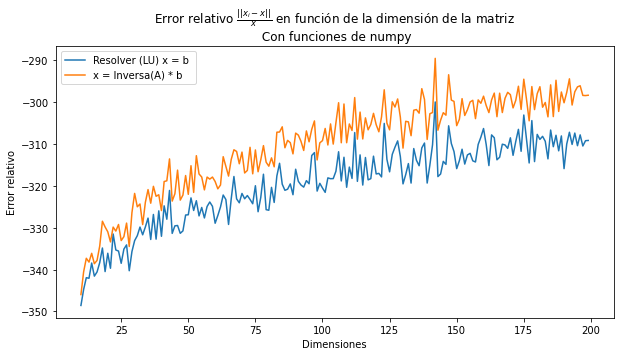

In [30]:
plt.plot(np.arange(min_dim, max_dim, step), v1[min_dim:], label="Resolver (LU) x = b ")
plt.plot(np.arange(min_dim, max_dim, step), v2[min_dim:], label="x = Inversa(A) * b")
plt.title("Error relativo " r"$\frac{||x_i - x||}{x}$" + " en función de la dimensión de la matriz\n Con funciones de numpy")
plt.xlabel("Dimensiones")
plt.ylabel("Error relativo")
plt.legend()
plt.show()

> **¿Observan el mismo comportamiento?**
>
> El comportamiento es similar, pero ligeramente diferente, como por ejemplo la distancia entre curvas algo mayor, los valores máximos unas 50 unidades por debajo de los medidos en el ejercicio 8, y una pendiente que decrece más rápidamente a medida que aumentan las dimensiones.
>
> La velocidad de ejecución es mucho mayor en este caso como se aclaró anteriormente, pasando de ~50 segundos a ~2 segundos.

### Ejercicio 10

In [31]:
def generarMatrizHilbert(n):
    """
    Genera una matriz de Hilbert de tamaño n x n.

    Una matriz de Hilbert es una matriz cuadrada donde cada elemento H[i, j]
    es igual a 1 / (i + j + 1).

    Args:
        n (int): Dimensión de la matriz de Hilbert (n x n).

    Returns:
        numpy.ndarray: La matriz de Hilbert de tamaño n x n.
    """
    ind_row, ind_col = np.indices((n, n))
    T = 1 + ind_row + ind_col
    H = 1/T
    return H

In [32]:
def experimento_ej10(min_dim=2, max_dim=20, iteraciones=10):
    """
    Realiza un experimento con matrices de Hilbert de diversas dimensiones y calcula errores relativos.

    Se generan matrices de Hilbert de dimensiones n x n, donde n varía desde min_dim hasta max_dim.
    Para cada matriz y cada iteración, se calculan errores relativos para dos métodos (LU e inversa).

    Args:
        min_dim (int): Dimensión mínima de las matrices de Hilbert.
        max_dim (int): Dimensión máxima de las matrices de Hilbert.
        iteraciones (int): Número de iteraciones por cada dimensión.

    Returns:
        Tuple: Una tupla con los siguientes elementos en orden:
            - v1 (list): Errores cometidos por el método con LU.
            - v2 (list): Errores cometidos por el método con inversa.
    """
    dimensiones = np.arange(min_dim, max_dim)

    v1, v2 = [0]*min_dim, [0]*min_dim

    for n in tqdm(dimensiones):
        sum_e1 = 0
        sum_e2 = 0
        for i in range(iteraciones):
            A = generarMatrizHilbert(n)
            x = np.random.uniform(low=-1., high=1., size=(n, 1))
            
            e1, e2 = errores_ej7(A, x)

            sum_e1 += e1
            sum_e2 += e2
        v1.append(sum_e1)
        v2.append(sum_e2)
    
    return v1, v2

In [33]:
min_dim = 2
max_dim = 20
iteraciones=10
v1, v2 = experimento_ej10(min_dim, max_dim, iteraciones)

  0%|          | 0/18 [00:00<?, ?it/s]<ipython-input-16-0d8cc11c45e2>:17: RuntimeWarning: divide by zero encountered in log
  e1 = np.log(e1)
<ipython-input-16-0d8cc11c45e2>:21: RuntimeWarning: divide by zero encountered in log
  e2 = np.log(e2)
100%|██████████| 18/18 [00:00<00:00, 84.91it/s] 


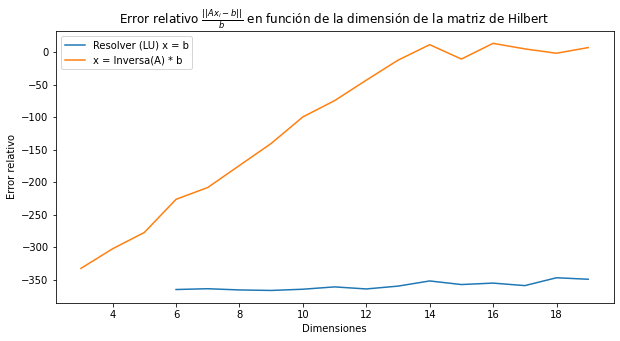

In [34]:
plt.plot(np.arange(min_dim, max_dim), v1[min_dim:], label="Resolver (LU) x = b")
plt.plot(np.arange(min_dim, max_dim), v2[min_dim:], label="x = Inversa(A) * b")
plt.title("Error relativo " r"$\frac{||Ax_i - b||}{b}$" + " en función de la dimensión de la matriz de Hilbert")
plt.xlabel("Dimensiones")
plt.ylabel("Error relativo")
plt.legend()
plt.show()

**Observaciones:**

> Para dimensiones entre 2 y 10 (aproximadamente, dependiendo las matrices generadas) se observan valores faltantes que se corresponden con errores de cálculo al obtener un error relativo de cero y calcularle el logaritmo.
>
> Éste comportamiento no habia sido observado anteriormente porque en todos los experimentos usamos matrices de dimensiones mayores o iguales a 10. Una rápida modificación de los parámetros de dimensión mínima del ejercicio 7 muestra que también aparecen mensajes de error al calcular el logaritmo de cero.
>
> Lo que nos dice ésto es que al calcular la norma $||Ax_i - b||$ estamos obteniendo cero, o sea, que $Ax_i$ es exactamente igual a $b$.
>
> En el caso de la matriz de Hilbert vemos que este tipo de error sucede mayoritariamente (o exclusivamente) para el método de `Resolver (LU) x = b` correspondiente con la curva azul, lo que nos dice que éste método tiene un error muy cercano a cero o exactamente cero, lo cual es preferible. Además se mantiene muy cerca del valor -350 para todas las dimensiones entre 2 y 20.

> Por otro lado, el método de resolver la inversa muestra un crecimiento lineal con la dimensión que, como estamos en escala logarítmica, representa un crecimiento exponencial del error que llega rápidamente a su máximo para la dimensión 14, y allí se mantiene constante, aunque es probable que sea por la naturaleza de las matrices que tienen valores entre -1 y 1 y redondeo numérico, y no porque a partir de la dimensión 14 la matriz mantenga su estabilidad numérica, como se ve a continuación con el número de condición (que tiende a infinito).

**Número de Condición**

A continuación se calcula el número de condición de matrices de Hilbert entre 2 y 20 dimensiones, como también su norma 2 y la de su inversa.

In [35]:
conds = []
for n in range (2, 20):
    A = generarMatrizHilbert(n)
    conds.append(np.linalg.cond(A, p=2))

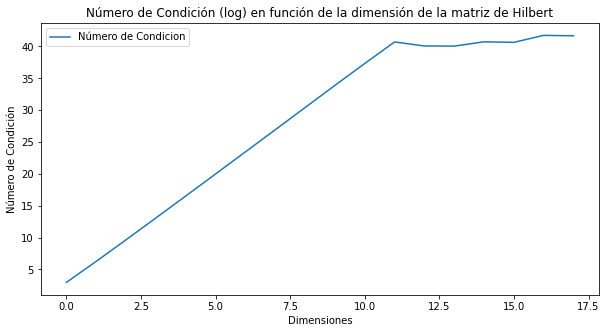

In [36]:
plt.plot(np.log(conds), label="Número de Condicion")
plt.title("Número de Condición (log) en función de la dimensión de la matriz de Hilbert")
plt.xlabel("Dimensiones")
plt.ylabel("Número de Condición")
plt.legend()
plt.show()

**Observación:**

> Notamos cómo el gráfico de número de condición tiene un comportamiento **muy** similar al del error relativo del método de la inversa descripto más arriba.
>
> Ésto muestra una relación directa entre el número de condición de una matriz y el error que se puede generar al operar con la misma directamente. Como el número de condición de una matriz es igual al de su inversa, pues:
> $$\text{cond} \ A = ||A|| \ ||A^{-1}|| = \text{cond} \ A^{-1} $$
> entonces el método de usar la inversa de una matriz para calcular $x$ a partir de $A^{-1}b$ será muy inestable numericamente para este tipo de matrices, y es por eso que es muy conveniente usar algun tipo de descomposición que reduzca la inestabilidad del sistema a resolver a partir de utilizar matrices triangulares en un sistema equivalente.


## Conclusiones Finales

A partir de la implementación de funciones que permitieron descomponer una matriz cualquiera en matrices triangulares L y U, y de operar con ellas para poder resolver sistemas, calcular distintos tipos de errores relativos y la inversa de una matriz, se implementaron experimentos de simulación para visualizar y comparar los comportamientos de los distintos métodos.

De esta manera pudimos observar gráficamente cómo utilizar la descomposición LU suele tener menos error que su contraparte de resolver la inversa para resolver un sistema.

El caso extremo se dio finalmente en el ejercicio 10 con una matriz de Hilbert, donde usar la descomposición LU genera errores muy pequeños para todas las dimensiones (es más, para las dimensiones más pequeñas es exactamente cero), mientras que resolver la inversa calculando primero la inversa genera un error que aumenta de manera exponencial con la dimensión.

Queda claro que el uso de la inversa para resolver un sistema es una gran herramienta teórica, pero que al llevarla a la práctica implica tener que buscar alternativas (como la descomposición LU, PLU, etc) que resuelvan un sistema equivalente pero de manera más estable, considerando las limitaciones de los números de máquina de punto flotante que usa cualquier tipo de computadora.  